### Assumptions

1. All numeric columns considered for model build
2. Missing values were substituted for zero as they meant bad data
3. Neural Network architecture was implemented due to large data size
4. since the aim was to build a predictive model to predict the failures from the sensor measurement data, If the next failure happened in less than 3 hours, the row was tagged as a failure.
5. The option of 3 hours was considered to reduce imbalance data as much as possible.

In [ ]:
  #Check for runtime environment:
!nvidia-smi

Thu Nov 26 21:13:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  !pip uninstall tb-nightly tensorboardX tensorboard
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

Uninstalling tb-nightly-2.5.0a20201126:
  Would remove:
    /usr/local/bin/tensorboard
    /usr/local/lib/python3.6/dist-packages/tb_nightly-2.5.0a20201126.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorboard/*
Proceed (y/n)? y
  Successfully uninstalled tb-nightly-2.5.0a20201126
  Using cached https://files.pythonhosted.org/packages/f6/f6/76b303d8b3aed46e53ab9bdfb4ccc14952bc9fe34f24318966e763032509/tb_nightly-2.5.0a20201126-py3-none-any.whl


In [ ]:
#Import python libraries:
import numpy as np
import pandas as pd
import re
import sys
import os
from google.colab import drive 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import classification_report

In [ ]:
%%shell
jupyter nbconvert "gdrive/My Drive/docs/Code_Solutions.ipynb"

[NbConvertApp] WARNING | pattern u'gdrive/My Drive/docs/Code_Solutions.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'noteboo

CalledProcessError: ignored

In [ ]:
#Mount google drive folders:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%shell
jupyter nbconvert --to html 'gdrive/My Drive/docs/Case_Study_Asst_Code_Solution.ipynb'

[NbConvertApp] Converting notebook gdrive/My Drive/docs/Case_Study_Asst_Code_Solution.ipynb to html
[NbConvertApp] Writing 711866 bytes to gdrive/My Drive/docs/Case_Study_Asst_Code_Solution.html


In [ ]:
#Import sensor data:
df1=pd.read_excel('gdrive/My Drive/main_pred/maint_data.xlsx', sheet_name="Sensor_Data")

In [ ]:
df1.head()

,Timestamp,AI552051.754,AI552051.754_ALM,BACT.552051,BCMPLT.552051,CYCLE.552051,FAL552051.754,FI552051_718,FIC552051_718,FQI552051.718,HV552051.331,HV552051.332,LAH552051.670,LAH552051.678,LAH552051.680,M552051.801,M552051.802,M552051.823,M552051.826,M552051.871,MAINT.552051,MODMAN.552051,MODSTS.552051,PARTREC.552051,PHASE.552051,PHTIME.552051,PI552051.641,PI552051.642,PI552051.645,PI552051.646,PI552051.651,PIN.552051,QCA552051_001,RUN.552051,SI552051.801,SIA552051.801,SIC552051.801,SIC552051.801_ALM,SIC552051.801_CO,SIC552051.801_SP,SSOALM.552051,TIC552051.616,VI552051.748,VI552051.748_ALM,WI552051.674,WI552051.675,ZS552051.737,ZS552051.740,ZS552051_753
0,2015-04-01 00:00:00,0.0851305,Normal,Active,Active,0,off,0.0120094,12.0093,208.417,No Data,No Data,on,on,on,on,off,off,off,off,off,Auto,8,Man,21,2.6982,0.042778,0.0671844,0.00863647,0.0312439,0.0409317,152168,No Data,RUN,899.248,1023.55,902.125,Normal,52.7688,894.751,Normal,18.4833,0.838046,Normal,103.945,3726.58,No Data,No Data,No Data
1,2015-04-01 00:10:00,0.0854137,Normal,Active,Active,0,off,0.0120094,12.0093,208.455,No Data,No Data,on,on,on,on,on,off,off,on,off,Auto,8,Auto,23,2.69822,0.0428749,0.0672325,0.00829468,0.0326204,0.0424194,152168,No Data,RUN,348.771,385.641,348.34,Normal,21.809,348.219,Normal,18.4854,0.353471,Normal,103.945,3726.92,No Data,No Data,No Data
2,2015-04-01 00:20:00,0.0856969,Normal,Active,Active,0,off,0.0120094,12.0093,208.492,No Data,No Data,on,on,on,on,on,off,off,on,off,Auto,8,Auto,23,2.69823,0.0418024,0.0671844,0.00798285,0.0323454,0.0417448,152168,No Data,RUN,350.102,408.028,351.204,Normal,21.3389,345.316,Normal,18.4875,0.299794,Normal,103.945,3727.26,No Data,No Data,No Data
3,2015-04-01 00:30:00,0.0859801,Normal,Active,Active,0,off,0.0120094,12.0093,208.53,No Data,No Data,on,on,on,on,on,off,off,on,off,Auto,8,Auto,23,2.69825,0.0427198,0.0671844,0.00863647,0.0331938,0.0416641,152168,No Data,RUN,64.4745,71.6029,63.4246,Normal,6.17651,71.0554,Normal,18.4896,0.129283,Normal,103.945,3727.6,No Data,No Data,No Data
4,2015-04-01 00:40:00,0.0862633,Normal,Active,Active,0,off,0.0120094,12.0093,208.568,No Data,No Data,on,on,on,on,on,off,off,on,off,Auto,8,Man,23,2.69826,0.0419921,0.0679398,0.00904312,0.0333645,0.041751,152168,No Data,RUN,64.3246,92.7012,67.5525,Normal,5.77139,73.2241,Normal,18.4916,0.151732,Normal,103.945,3727.94,No Data,No Data,No Data


In [ ]:
#Convert numeric columns to numeric data type:
lst = ["AI552051.754",
       "CYCLE.552051",
       "FI552051_718",
       "FIC552051_718",
       "FQI552051.718",
       "MODSTS.552051",
       "PHASE.552051",
       "PHTIME.552051",
       "PI552051.641",
       "PI552051.642",
       "PI552051.645",
       "PI552051.646",
       "PI552051.651",
       "PIN.552051",
       "SI552051.801",
       "SIA552051.801",
       "SIC552051.801",
       "SIC552051.801_CO",
       "SIC552051.801_SP",
       "TIC552051.616",
       "VI552051.748",
       "WI552051.674",
       "WI552051.675"]
df1[lst]  = df1[lst].apply(pd.to_numeric, errors='coerce')

In [ ]:
df2 = df1[["Timestamp"]].join(df1[lst]).reset_index(drop=True)
df2

,Timestamp,AI552051.754,CYCLE.552051,FI552051_718,FIC552051_718,FQI552051.718,MODSTS.552051,PHASE.552051,PHTIME.552051,PI552051.641,PI552051.642,PI552051.645,PI552051.646,PI552051.651,PIN.552051,SI552051.801,SIA552051.801,SIC552051.801,SIC552051.801_CO,SIC552051.801_SP,TIC552051.616,VI552051.748,WI552051.674,WI552051.675
0,2015-04-01 00:00:00,0.085130,0.0,0.012009,12.009277,208.416672,8.0,21.0,2.698205,0.042778,0.067184,0.008636,0.031244,0.040932,152168.0,899.247742,1023.552063,902.125244,52.768764,894.751160,18.483295,0.838046,103.945312,3726.583008
1,2015-04-01 00:10:00,0.085414,0.0,0.012009,12.009277,208.454514,8.0,23.0,2.698218,0.042875,0.067232,0.008295,0.032620,0.042419,152168.0,348.770844,385.640625,348.340118,21.809050,348.219360,18.485382,0.353471,103.945312,3726.921875
2,2015-04-01 00:20:00,0.085697,0.0,0.012009,12.009277,208.492371,8.0,23.0,2.698231,0.041802,0.067184,0.007983,0.032345,0.041745,152168.0,350.101562,408.028137,351.204254,21.338938,345.316132,18.487471,0.299794,103.945312,3727.260742
3,2015-04-01 00:30:00,0.085980,0.0,0.012009,12.009277,208.530212,8.0,23.0,2.698245,0.042720,0.067184,0.008636,0.033194,0.041664,152168.0,64.474487,71.602867,63.424610,6.176514,71.055420,18.489557,0.129283,103.945312,3727.599365
4,2015-04-01 00:40:00,0.086263,0.0,0.012009,12.009277,208.568069,8.0,23.0,2.698258,0.041992,0.067940,0.009043,0.033364,0.041751,152168.0,64.324638,92.701172,67.552536,5.771387,73.224098,18.491646,0.151732,103.945312,3727.938232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109004,2017-04-26 23:20:00,10.675984,0.0,NaN,0.000000,0.000000,0.0,1.0,0.000000,-0.001531,0.057458,0.007904,0.001017,0.009948,152168.0,-1.727458,NaN,-1.686614,104.978516,0.000000,18.597149,-0.192683,114.082031,67.976280
109005,2017-04-26 23:30:00,10.672463,0.0,NaN,0.000000,0.000000,0.0,1.0,0.000000,-0.001531,0.057434,0.007577,0.001166,0.009502,152168.0,-1.737232,NaN,-1.675847,104.977707,0.000000,18.596098,-0.193414,114.082031,67.869576
109006,2017-04-26 23:40:00,10.668943,0.0,NaN,0.000000,0.000000,0.0,1.0,0.000000,-0.001531,0.057434,0.006393,0.000616,0.008636,152168.0,-1.747006,NaN,-1.665080,104.976891,0.000000,18.595049,-0.194145,114.082031,67.762878
109007,2017-04-26 23:50:00,10.665423,0.0,NaN,0.000000,0.000000,0.0,1.0,0.000000,-0.001531,0.058043,0.007520,0.001015,0.008636,152168.0,-1.756780,NaN,-1.654312,104.976074,0.000000,18.593998,-0.194876,114.082031,67.656174


In [ ]:
#Add gadget id column:
df2["gadget_id"] = "1"

In [ ]:
#Check for missing values:
df2.isnull().sum()

Timestamp               0
AI552051.754           35
CYCLE.552051           23
FI552051_718         9457
FIC552051_718          24
FQI552051.718          24
MODSTS.552051          23
PHASE.552051           23
PHTIME.552051          22
PI552051.641           23
PI552051.642           24
PI552051.645           23
PI552051.646           24
PI552051.651           24
PIN.552051             23
SI552051.801           24
SIA552051.801       65285
SIC552051.801          23
SIC552051.801_CO       23
SIC552051.801_SP       23
TIC552051.616          24
VI552051.748           31
WI552051.674           23
WI552051.675           23
gadget_id               0
dtype: int64

In [ ]:
#Substituting  missing values:
df2 = df2.fillna(0)

In [ ]:
#Check for missing values:
df2.isnull().sum()

Timestamp           0
AI552051.754        0
CYCLE.552051        0
FI552051_718        0
FIC552051_718       0
FQI552051.718       0
MODSTS.552051       0
PHASE.552051        0
PHTIME.552051       0
PI552051.641        0
PI552051.642        0
PI552051.645        0
PI552051.646        0
PI552051.651        0
PIN.552051          0
SI552051.801        0
SIA552051.801       0
SIC552051.801       0
SIC552051.801_CO    0
SIC552051.801_SP    0
TIC552051.616       0
VI552051.748        0
WI552051.674        0
WI552051.675        0
gadget_id           0
dtype: int64

In [ ]:
#Import sensor data:
df3=pd.read_excel('gdrive/My Drive/main_pred/maint_data.xlsx', sheet_name="Failure_Data")


In [ ]:
#Check for head:
df3.head()

,Order Type,Order Type Description,Functional Location,Unnamed: 3,Maintenance Order,Maintenance Order Details,Notification,Breakdown indicator,FailureStartDate,FailureStartTime,actual work\nin hours
0,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51059487,Repair cables on production inlet CV and,11162778,#,11.03.2015,07:31:04,2.0
1,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51064370,overhaul screw from 552 051,11168557,#,19.03.2015,15:22:07,16.0
2,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51071633,sightglass leaking on centrifuge,11176841,#,02.04.2015,11:30:26,7.5
3,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51191489,Gearbox for the screw leaking oil from f,11313660,#,30.10.2015,12:58:39,4.0
4,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51206628,Measure the distance of the knife from t,11330483,#,26.11.2015,10:07:23,6.0


In [ ]:
#Check for shape:
df3.shape

(25, 11)

In [ ]:
#Convert date time columns to date time format:
df3["failure_time"] = pd.to_datetime(df3['FailureStartDate'] + ' ' + df3['FailureStartTime'])

In [ ]:
#Add gadget id column:
df3["gadget_id"] = "1"

In [ ]:
df3.head()

,Order Type,Order Type Description,Functional Location,Unnamed: 3,Maintenance Order,Maintenance Order Details,Notification,Breakdown indicator,FailureStartDate,FailureStartTime,actual work\nin hours,failure_time,gadget_id
0,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51059487,Repair cables on production inlet CV and,11162778,#,11.03.2015,07:31:04,2.0,2015-11-03 07:31:04,1
1,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51064370,overhaul screw from 552 051,11168557,#,19.03.2015,15:22:07,16.0,2015-03-19 15:22:07,1
2,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51071633,sightglass leaking on centrifuge,11176841,#,02.04.2015,11:30:26,7.5,2015-02-04 11:30:26,1
3,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51191489,Gearbox for the screw leaking oil from f,11313660,#,30.10.2015,12:58:39,4.0,2015-10-30 12:58:39,1
4,PM11,0C: Deferred Maintenance,IE01.552.051.001,CENTRIFUGE - HORIZONTAL,51206628,Measure the distance of the knife from t,11330483,#,26.11.2015,10:07:23,6.0,2015-11-26 10:07:23,1


In [ ]:
#Rename & sort columns:
df_measurements = df2.copy()
df_failures = df3.copy()
df_failures = df_failures[["gadget_id","failure_time"]]
df_measurements = df_measurements.sort_values(by=['Timestamp'], ascending=[True])
df_failures = df_failures.sort_values(by=['failure_time'], ascending=[True])

In [ ]:
### Merge failure to timestamp
df_combined = pd.merge_asof(
    df_measurements,
    df_failures,
    left_on='Timestamp',
    right_on = 'failure_time',
    by='gadget_id',
    direction='forward'
)

In [ ]:
### Transform columns
df_combined['time_to_fail'] = df_combined['failure_time']-df_combined['Timestamp']
df_combined['fail_in_3h'] = np.where(df_combined['time_to_fail']<pd.Timedelta(hours=3), 1, 0)

In [ ]:
df_final = df_combined.drop(["Timestamp","gadget_id","failure_time","time_to_fail","fail_in_3h"], axis=1)
df_final = df_combined[["fail_in_3h"]].join(df_final).reset_index(drop=True)
df_final.head()

,fail_in_3h,AI552051.754,CYCLE.552051,FI552051_718,FIC552051_718,FQI552051.718,MODSTS.552051,PHASE.552051,PHTIME.552051,PI552051.641,PI552051.642,PI552051.645,PI552051.646,PI552051.651,PIN.552051,SI552051.801,SIA552051.801,SIC552051.801,SIC552051.801_CO,SIC552051.801_SP,TIC552051.616,VI552051.748,WI552051.674,WI552051.675
0,0,0.085130,0.0,0.012009,12.009277,208.416672,8.0,21.0,2.698205,0.042778,0.067184,0.008636,0.031244,0.040932,152168.0,899.247742,1023.552063,902.125244,52.768764,894.751160,18.483295,0.838046,103.945312,3726.583008
1,0,0.085414,0.0,0.012009,12.009277,208.454514,8.0,23.0,2.698218,0.042875,0.067232,0.008295,0.032620,0.042419,152168.0,348.770844,385.640625,348.340118,21.809050,348.219360,18.485382,0.353471,103.945312,3726.921875
2,0,0.085697,0.0,0.012009,12.009277,208.492371,8.0,23.0,2.698231,0.041802,0.067184,0.007983,0.032345,0.041745,152168.0,350.101562,408.028137,351.204254,21.338938,345.316132,18.487471,0.299794,103.945312,3727.260742
3,0,0.085980,0.0,0.012009,12.009277,208.530212,8.0,23.0,2.698245,0.042720,0.067184,0.008636,0.033194,0.041664,152168.0,64.474487,71.602867,63.424610,6.176514,71.055420,18.489557,0.129283,103.945312,3727.599365
4,0,0.086263,0.0,0.012009,12.009277,208.568069,8.0,23.0,2.698258,0.041992,0.067940,0.009043,0.033364,0.041751,152168.0,64.324638,92.701172,67.552536,5.771387,73.224098,18.491646,0.151732,103.945312,3727.938232


In [ ]:
#Split data into train and test:
train_data, test_data, train_labels, test_labels = train_test_split(df_final.values, df_final.values[:,0:1], test_size=0.20, random_state=111, stratify=df_final.values[:,0:1])

In [ ]:
#Normalize data:
scaler = StandardScaler()
data_scaled = scaler.fit(train_data)
train_data_scaled = data_scaled.transform(train_data)
test_data_scaled = data_scaled.transform(test_data)

In [ ]:
#Convert back to dataframe:
train_data_scaled = pd.DataFrame(train_data_scaled).values[:,1:]
test_data_scaled = pd.DataFrame(test_data_scaled).values[:,1:]

In [ ]:
#Implement artificial neural network model:
model = tf.keras.Sequential()
for units in [64, 32,16]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))
  model.add(tf.keras.layers.Dropout(units*0.006))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

In [ ]:
#Implement early stopping:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    #patience=2,
                                                    mode='min')

In [ ]:
#Compile the model:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
#Fit the model:
history=model.fit(train_data_scaled, 
                  train_labels, epochs=50, 
                  batch_size=1024, 
                  validation_data=(test_data_scaled, test_labels), 
                  shuffle=True,
                  callbacks=[early_stopping],
                  class_weight={0: 0.01, 1: 0.99})

Epoch 1/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0082 - accuracy: 0.9147 - val_loss: 0.2982 - val_accuracy: 0.9966
Epoch 2/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0069 - accuracy: 0.9864 - val_loss: 0.2515 - val_accuracy: 0.9945
Epoch 3/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0066 - accuracy: 0.9838 - val_loss: 0.2090 - val_accuracy: 0.9841
Epoch 4/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0057 - accuracy: 0.9738 - val_loss: 0.2009 - val_accuracy: 0.9582
Epoch 5/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 0.9577 - val_loss: 0.1895 - val_accuracy: 0.9398
Epoch 6/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.9437 - val_loss: 0.1418 - val_accuracy: 0.9501
Epoch 7/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 0.9462 - val_loss: 0.1896 - val_accuracy: 0.9178


In [ ]:
#Calculate classification metrics:
y_pred=model.predict_classes(test_data_scaled)
print(classification_report(test_labels, y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     21734
         1.0       0.03      0.82      0.06        68

    accuracy                           0.92     21802
   macro avg       0.51      0.87      0.51     21802
weighted avg       1.00      0.92      0.95     21802



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, y_pred)

array([[19954,  1780],
       [   12,    56]])

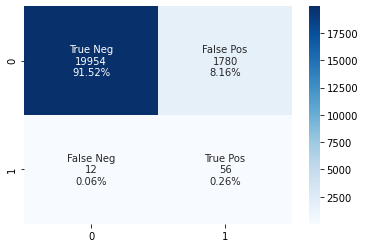

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_labels, y_pred)
import seaborn as sns
#sns.heatmap(cf_matrix, annot=True)
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [ ]:
lst = y_pred.tolist()
data = pd.DataFrame({"failure_pred":lst}).reset_index(drop=True)
data = data.join(pd.DataFrame(test_data)).reset_index(drop=True)
data = data.rename(columns={0:"pred_observed"})
data["failure_pred"] = data["failure_pred"].str.get(0)
data.head()

,failure_pred,pred_observed,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0,0.0,1.647040,0.0,0.012009,12.009277,0.0,12.0,31.0,0.549988,0.001280,0.078625,0.013145,0.001853,0.011007,802304.0,-1.501190,0.000000,-1.209335,105.0,0.0,19.435667,-0.016013,183.472656,80.699219
1,0,0.0,4.460329,0.0,0.000000,-578.453125,0.0,8.0,27.0,0.608337,0.005034,0.080597,0.006805,0.000416,0.007261,152168.0,-1.717621,0.000000,-1.735789,105.0,0.0,18.888178,-0.077882,114.246094,66.000000
2,0,0.0,4.291536,0.0,0.014763,14.511475,0.0,8.0,27.0,2.912693,0.003798,0.054539,0.014032,0.000902,0.009523,152168.0,-1.490723,0.000000,-1.501190,105.0,0.0,18.934065,0.004003,259.296875,150.998596
3,1,0.0,7.711868,0.0,0.014512,12.009277,0.0,8.0,27.0,3.122074,0.002777,0.047797,0.012503,0.000716,0.009814,152168.0,-1.487741,0.000000,-1.488251,105.0,0.0,18.723835,-0.005925,414.343750,69.522926
4,0,0.0,0.286476,0.0,0.014512,14.511475,0.0,8.0,27.0,6.549927,0.018289,0.057540,0.008120,0.033446,0.041042,152168.0,-1.501190,-4.697998,-1.491838,105.0,0.0,19.897367,0.034027,103.945312,83.894531
